    Ben Christensen
    Math 403
    October 1, 2018

Scrape data from websites using BeautifulSoup and Selenium

In [1]:
import re
import time
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Problem 1
def scrape_books(start_page = "index.html"):
    """ Crawl through http://books.toscrape.com and extract fiction data"""

    # Initialize variables, including a regex for finding the 'next' link.
    base_url="http://books.toscrape.com/catalogue/category/books/fiction_10/"
    price_total = []
    count_total = []
    page = base_url + start_page                # Complete page URL.
    next_page_finder = re.compile(r"next")      # We need this button.
    current = None

    for _ in range(4):
        total = 0
        count = 0

        while current == None:                   # Try downloading until it works.
            # Download the page source and PAUSE before continuing.
            page_source = requests.get(page).text
            time.sleep(1)           # PAUSE before continuing.
            soup = BeautifulSoup(page_source, "html.parser")
            current = soup.find_all(class_="price_color")

        #Extract the price data.
        for price in current:
            total += float(price.string.strip("Â£"))
            count += 1

        price_total.append(total)
        count_total.append(count)


        if "page-4" not in page:
            # Find the URL for the page with the next data.
            new_page = soup.find(string=next_page_finder).parent["href"]
            page = base_url + new_page      # New complete page URL.
            current = None
        else:
            # Calculate the price average
            average_price = sum(price_total)/sum(count_total)
    return average_price

# Problem 2
def bank_data():
    """Crawl through the Federal Reserve site and extract bank data."""
    # Compile regular expressions for finding certain tags.
    link_finder = re.compile(r"^December 31, 20((0[4-9])|(1[0-8]))$")
    chase_bank_finder = re.compile(r"^JPMORGAN CHASE BK")
    america_bank_finder = re.compile(r"^BANK OF AMER")
    fargo_bank_finder = re.compile(r"^WELLS FARGO BK")

    # Get the base page and find the URLs to all other relevant pages.
    base_url="https://www.federalreserve.gov/releases/lbr/"
    base_page_source = requests.get(base_url).text
    base_soup = BeautifulSoup(base_page_source, "html.parser")
    link_tags = base_soup.find_all(name='a', href=True, string=link_finder)
    pages = [base_url + tag.attrs["href"] for tag in link_tags]

    # Crawl through the individual pages and record the data.
    chase_assets = []
    america_assets = []
    fargo_assets = []
    for page in pages:
        time.sleep(1)               # PAUSE, then request the page.
        soup = BeautifulSoup(requests.get(page).text, "html.parser")

        # Find the tag corresponding to Chase Banks's consolidated assets.
        temp_tag1 = soup.find(name="td", string=chase_bank_finder)
        temp_tag2 = soup.find(name="td", string=america_bank_finder)
        temp_tag3 = soup.find(name="td", string=fargo_bank_finder)
        for _ in range(10):
            temp_tag1 = temp_tag1.next_sibling
            temp_tag2 = temp_tag2.next_sibling
            temp_tag3 = temp_tag3.next_sibling
        # Extract the data, removing commas.
        chase_assets.append(int(temp_tag1.string.replace(',', '')))
        america_assets.append(int(temp_tag2.string.replace(',', '')))
        fargo_assets.append(int(temp_tag3.string.replace(',', '')))

    years = np.arange(2004, 2018)
    #Plot the total consolidated assets for these banks from 2004-2018
    plt.plot(years, chase_assets, label="JPMorgan Chase")
    plt.plot(years, america_assets, label="Bank of America")
    plt.plot(years, fargo_assets, label="Wells Fargo")
    plt.title("Total Consolidated Assets of Several Banks from 2004-2018")
    plt.xlabel("year")
    plt.ylabel("Millions of Dollars")
    plt.legend()
    plt.tight_layout()
    plt.show()



# Problem 3
def prob3():
    """ESPN hosts data on NBA athletes at
    http://www.espn.go.com/nba/statistics. Each player has their own page with
    detailed performance statistics. For each of the five offensive leaders in
    points and each of the five defensive leaders in rebounds, extract the
    player’s career minutes per game (MPG) and career points per game (PPG).
    Make a scatter plot of MPG against PPG for these ten players.
    """
    #The next season is given by the link with class_ == "button2 next"
    link_finder = re.compile(r"^button2 next$")
    name_finder = re.compile(r"[A-Za-z]+ [A-Za-z]+ •")
    points_finder = re.compile(r"\d+[^.]")
    base_url= "https://www.basketball-reference.com/"
    page = base_url + "leagues/NBA_2009_leaders.html"
    base_page_source = requests.get(base_url).text
    soup = BeautifulSoup(base_page_source, "html.parser")
    #Prime  lists to return
    names = []
    points = []
    seasons=[]
    for i in range(8,18):
        if i == 8:
            seasons.append("2008-09")
        elif i == 9:
            seasons.append("2009-10")
        else:
            seasons.append("20"+str(i)+"-"+str(i+1))
    for year in np.arange(2008,2018):
        #Wait a second to scrape the page
        time.sleep(1)
        soup = BeautifulSoup(requests.get(page).text, "html.parser")
        #Find the player with the most points
        tag = soup.find(name="caption", attrs={"data-tip":"Points"})
        names.append(name_finder.search(tag.next_sibling.next_sibling.text).group()[:-2])
        points.append(points_finder.search(tag.next_sibling.next_sibling.text).group()[:-1])
        #Go to the next page (season)
        link_tag = soup.find(name='a', href=True, class_=link_finder)
        page = base_url + link_tag.attrs["href"]

    return [(seasons[i], names[i], int(points[i])) for i in range(10)]



# Problem 4
def prob4(search_query):
    """Use Selenium to enter the given search query into the search bar of
    https://arxiv.org and press Enter. The resulting page has up to 25 links
    to the PDFs of technical papers that match the query. Gather these URLs,
    then continue to the next page (if there are more results) and continue
    gathering links until obtaining at most 100 URLs. Return the list of URLs.

    Returns:
        (list): Up to 100 URLs that lead directly to PDFs on arXiv.
    """
    #Open a Chrome browser window
    browser = webdriver.Chrome()
    base_url = "https://arxiv.org/"
    try:
        #Navigate to to the archive we want to search
        browser.get(base_url)
        try:
            #Get the search bar and search for the string provided as input
            search_bar = browser.find_element_by_name("query")
            search_bar.clear()
            search_bar.send_keys(search_query)
            search_bar.send_keys(Keys.RETURN)
        except NoSuchElementException:
            print("Could not find the search bar!")
            raise
        #Create a BeautifulSoup object of the html source code to find and
        #   manipulate tags.
        soup = BeautifulSoup(browser.page_source, "html.parser")
        pdf_links = [tag["href"] for tag in soup.find_all(name="a", string="pdf")]
        while len(pdf_links) < 150:
            #Go to the next page
            next_page_link = base_url + soup.find(name='a', class_="pagination-next").attrs["href"]
            browser.get(next_page_link)
            soup = BeautifulSoup(browser.page_source, "html.parser")
            #Append the links of every pdf on the new page
            for tag in soup.find_all(name='a', string='pdf'):
                pdf_links.append(tag["href"])

    finally:
        #Close the browser
        browser.close()

    return pdf_links[:150]


# Problem 5
def prob5():
    """For each of the (at least) 600 problems in the archive at
    https://projecteuler.net/archives, record the problem ID and the number of
    people who have solved it. Return a list of IDs, sorted from largest to
    smallest by the number of people who have solved them. That is, the first
    entry in the list should be the ID of the most solved problem, and the
    last entry in the list should be the ID of the least solved problem.

    Returns:
        (list): problem IDs (as strings), from most solved to least solved.
    """
    base_url = "https://projecteuler.net/archives"
    #IDs for each problem
    IDs = [str(i) for i in range(1,628)]
    descriptions = []
    num_solvers = []
    #Find all of the pages we need to use
    pages = [base_url]
    for i in range(2,14):
        pages.append(base_url + ";page=" + str(i))
    #Open a browser
    browser = webdriver.Chrome()

    try:
        for i, page in enumerate(pages):
            #Navigate to projecteuler.net
            browser.get(page)
            soup = BeautifulSoup(browser.page_source, "html.parser")
            #Get description and number of solvers for each problem on the page
            for ID in range(1 + i*50, 51 + i*50):
                link_name = "problem=" + str(ID)
                try:
                    descriptions.append(soup.find(name='a', href=link_name).string)
                except Exception as e:
                    if ID > 627:
                        break
                    else:
                        print("We ran into an unexpected error: ", e)
                        raise
            #Find the number of solvers for each problem on the page
            tags = soup.find_all(name='div', attrs={"style":"text-align:center;"})
            for tag in tags:
                num_solvers.append(int(tag.string))
    finally:
        browser.close()

    #Sort our lists of IDs and number of solvers in order from most solved to
    #   least solved.
    num_solvers, IDs = (list(t) for t in zip(*sorted(zip(num_solvers, IDs))))
    return IDs[::-1]



In [3]:
print("Average price of fiction books on toscrape.com:")
print(scrape_books())



Average price of fiction books on toscrape.com:
36.06661538461538


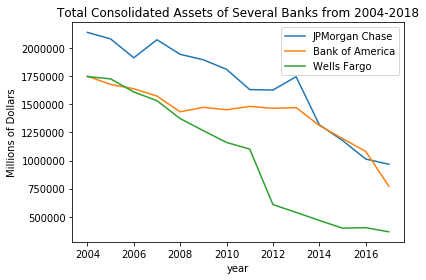

In [4]:
bank_data()

In [5]:
print("Top scoring NBA players for the past 10 seasons:")
results = prob3()
seasons = [entry[0] for entry in results]
names = [entry[1] for entry in results]
points = [entry[2] for entry in results]
print("Season |    Name    | Points")
for i, season in enumerate(seasons):
    print(season, names[i], points[i])

Top scoring NBA players for the past 10 seasons:
Season |    Name    | Points
2008-09 Dwyane Wade 2386
2009-10 Kevin Durant 2472
2010-11 Kevin Durant 2161
2011-12 Kevin Durant 1850
2012-13 Kevin Durant 2280
2013-14 Kevin Durant 2593
2014-15 James Harden 2217
2015-16 James Harden 2376
2016-17 Russell Westbrook 2558
2017-18 LeBron James 2251


In [6]:
print("Links for the top 10 articles from arxiv.org on Pareto efficiency.")
print(prob4("Pareto Efficiency")[:10])


Links for the top 10 articles from arxiv.org on Pareto efficiency.
['https://arxiv.org/pdf/1810.04650', 'https://arxiv.org/pdf/1810.04331', 'https://arxiv.org/pdf/1810.04259', 'https://arxiv.org/pdf/1810.03522', 'https://arxiv.org/pdf/1810.02990', 'https://arxiv.org/pdf/1810.00440', 'https://arxiv.org/pdf/1810.00031', 'https://arxiv.org/pdf/1809.10766', 'https://arxiv.org/pdf/1809.08489', 'https://arxiv.org/pdf/1809.06106']


In [7]:
print("Problem 5: All of the problems on projecteuler.net from most solved to least solved.")
print(prob5())

Problem 5: All of the problems on projecteuler.net from most solved to least solved.
['1', '2', '3', '6', '5', '4', '7', '9', '8', '10', '11', '16', '13', '14', '12', '20', '15', '25', '17', '21', '18', '19', '22', '24', '48', '30', '28', '29', '23', '67', '34', '36', '27', '35', '31', '26', '40', '42', '37', '39', '33', '45', '32', '41', '52', '38', '50', '46', '43', '53', '56', '44', '49', '47', '55', '97', '63', '79', '92', '59', '57', '58', '54', '81', '69', '51', '62', '99', '65', '71', '76', '74', '60', '73', '61', '85', '112', '206', '72', '70', '102', '64', '89', '82', '87', '68', '80', '66', '77', '83', '75', '96', '145', '78', '104', '100', '91', '205', '95', '124', '120', '125', '108', '86', '84', '119', '116', '94', '123', '93', '179', '187', '113', '98', '117', '101', '107', '90', '114', '115', '88', '121', '243', '173', '203', '110', '109', '105', '103', '122', '204', '357', '131', '191', '111', '134', '118', '188', '132', '135', '129', '106', '301', '144', '127', '174', 